In [1]:
import pandas as pd
import nlpaug.augmenter.word as naw
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import gensim

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
pd.options.mode.chained_assignment = None

/Users/nandangrover/miniforge3/envs/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../dmdlassignment2/AnnoMI/dataset.csv')
df.head()

,transcript_id,mi_quality,video_title,video_url,topic,utterance_id,interlocutor,timestamp,utterance_text,main_therapist_behaviour,client_talk_type
0,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,0,therapist,00:00:13,Thanks for filling it out. We give this form t...,question,NaN
1,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,1,client,00:00:24,Sure.,NaN,neutral
2,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,2,therapist,00:00:25,"So, let's see. It looks that you put-- You dri...",therapist_input,NaN
3,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,3,client,00:00:34,Mm-hmm.,NaN,neutral
4,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,4,therapist,00:00:34,-and you usually have three to four drinks whe...,therapist_input,NaN


# Data Cleaning and Preprocessing

In [3]:
import string
import re

stop_words = set(stopwords.words('english'))

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def tokenize(text):
    split=re.split("\W+",text.lower()) 
    return split

def remove_stopwords(text):
    text=[word for word in text if word not in stop_words]
    return text

def lemmatize(text):
    lemmatized_words = []
    for word in text:
        lemmatized_words.append(lemmatizer.lemmatize(word, pos="v"))
    return ' '.join(lemmatized_words)
    

In [4]:
transformed_df = pd.DataFrame(columns=['utterance_text', 'quality', 'topic'])

for index, topic in enumerate(df['topic'].unique()):
    tempdf = df[df['topic'] == topic]
    quality = df[df['topic'] == topic]['mi_quality'].unique()[0]

    # Apply an aggregation function
    combined_text = ' '.join(tempdf['utterance_text'].apply(''.join))
    transformed = lemmatize(remove_stopwords(tokenize(remove_punctuation(combined_text))))
    new_data = pd.Series({'utterance_text': transformed, 'quality': quality, 'topic': topic})
    transformed_df.loc[index] = new_data

transformed_df.head()

,utterance_text,quality,topic
0,thank fill give form everyone year regardless ...,high,reducing alcohol consumption
1,hi john nice see tell things go well doc know ...,high,weight loss; diet
2,well see mymy wifes get lot lately try improve...,high,problem recognition
3,hi emily hi yeah something new oh oh yeah yeah...,high,better oral health
4,hi billy hi hi another session another session...,high,reducing recidivism


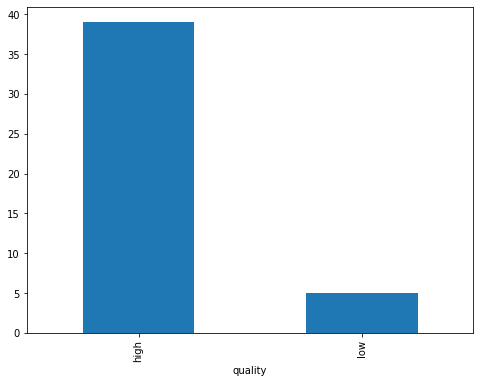

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
transformed_df.groupby('quality').utterance_text.count().plot.bar(ylim=0)
plt.show()

## Extract Labels

In [6]:
transformed_df['quality_id'] = transformed_df['quality'].factorize()[0]
# print(transformed_df[['quality', 'quality_id']].drop_duplicates().sort_values('quality_id').reset_index(drop=True))
quality_id_df = transformed_df[['quality', 'quality_id']].drop_duplicates().sort_values('quality_id')
quality_to_id = dict(quality_id_df.values)
id_to_quality = dict(quality_id_df[['quality_id', 'quality']].values)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(transformed_df.utterance_text).toarray()
labels = transformed_df.quality_id
print(features.shape)

(44, 1756)


## Extract the features and labels from the dataset

In [8]:
from sklearn.feature_selection import chi2
import numpy as np

N = 5
for quality_type, quality_type_id in sorted(quality_to_id.items()):
  print('Processing quality type {}'.format(quality_type))
  features_chi2 = chi2(features, labels == quality_type_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("------------------------------------------------------------------")
  print("# '{}':".format(quality_type))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

Processing quality type high
------------------------------------------------------------------
# 'high':
  . Most correlated unigrams:
. throat
. fair
. medication
. marijuana
. sorry
  . Most correlated bigrams:
. know smoke
. right ill
. uh want
. didnt want
. im sorry
Processing quality type low
------------------------------------------------------------------
# 'low':
  . Most correlated unigrams:
. throat
. fair
. medication
. marijuana
. sorry
  . Most correlated bigrams:
. know smoke
. right ill
. uh want
. didnt want
. im sorry


/Users/nandangrover/miniforge3/envs/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/nandangrover/miniforge3/envs/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Hyperparameter Tuning of the classifiers for the eventual Ensemble Classifier

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

processed_data = {}
def construct_model(dataframe):
    # the list of classifiers to use
    # use random_state for reproducibility
    classifiers = [
        LogisticRegression(random_state=0), 
        KNeighborsClassifier(), 
        RandomForestClassifier(random_state=0)
    ]
    
    logregress_parameters = {
        'penalty' : ['l2'],     
        'C'       : np.logspace(-3,3,7),
        'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    }
    knn_parameters = {
        'n_neighbors': np.arange(1, 25, 2)
    }
    randomforest_parameters = {
        'n_estimators': [50, 100, 200, 300]
    }
    # stores all the paramete rs in a list 
    parameters = [
        logregress_parameters, 
        knn_parameters, 
        randomforest_parameters
    ]
    # estimators is a list of tuple -> 
    #   [(name_of_classifier, tuned_estimator)]
    processed_data['estimators'] = []
    # iterate through each classifier and use GridSearchCV
    for i, classifier in enumerate(classifiers):
        clf = GridSearchCV(classifier,              # model
                  param_grid = parameters[i], # hyperparameters
                  scoring='accuracy',         # metric for scoring
                  cv=10,
                  n_jobs=-1, error_score='raise')
        X_train, processed_data['X_test'], y_train, processed_data['y_test'], indices_train, processed_data['indices_test'] = train_test_split(features, labels, dataframe.index, test_size=0.33, random_state=0, shuffle=True)
        clf.fit(X_train, y_train)
        # add the clf to the estimators list
        processed_data['estimators'].append((classifier.__class__.__name__, clf))  

In [13]:
construct_model(transformed_df)

# Accuracy for predicting client behaviour

In [14]:
for name, clf in processed_data['estimators']:
    print(name)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy :", clf.best_score_)
    print("__________________________________________________________")

LogisticRegression
Tuned Hyperparameters : {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.9
__________________________________________________________
KNeighborsClassifier
Tuned Hyperparameters : {'n_neighbors': 3}
Accuracy : 0.9
__________________________________________________________
RandomForestClassifier
Tuned Hyperparameters : {'n_estimators': 50}
Accuracy : 0.9
__________________________________________________________


## Ensemble Classifier

In [43]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(processed_data['estimators'], 
                            voting='hard', 
                            weights=[1,1,1], n_jobs=-1)  # n-estimators

X_train, processed_data['X_test'], y_train, processed_data['y_test'], indices_train, indices_test = train_test_split(features, labels, transformed_df.index, test_size=0.33, random_state=0, shuffle=True)

ensemble.fit(X_train, y_train)

/Users/nandangrover/miniforge3/envs/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/Users/nandangrover/miniforge3/envs/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/Users/nandangrover/miniforge3/envs/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


VotingClassifier(estimators=[('LogisticRegression',
                              GridSearchCV(cv=10, error_score='raise',
                                           estimator=LogisticRegression(random_state=0),
                                           n_jobs=-1,
                                           param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                                       'penalty': ['l2'],
                                                       'solver': ['newton-cg',
                                                                  'lbfgs',
                                                                  'liblinear']},
                                           scoring='accuracy')),
                             ('KNeighborsClassifier',
                              GridSearchCV(cv=10, error_...',
                                           estimator=KNeighborsClassifier(),
                                          

## Accuracy with the Ensemble Classifier reduces by around 3% each

In [44]:

accuracy = ensemble.score(processed_data['X_test'], processed_data['y_test'])
print("Ensemble classifier Accuracy:", accuracy)

Ensemble classifier Accuracy: 0.8666666666666667


## Heatmap for accuracy with tuned hyperparameters for Logistic Regression which gave the best accuracy

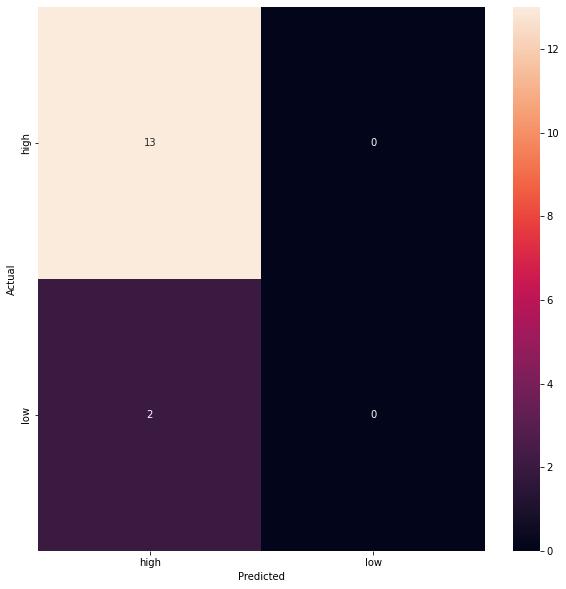

In [45]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

processed_data['y_pred'] = processed_data['estimators'][0][1].predict(processed_data['X_test'])
processed_data['conf_mat'] = confusion_matrix(processed_data['y_test'], processed_data['y_pred'])
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(processed_data['conf_mat'], annot=True, fmt='d',
            xticklabels=quality_id_df.quality.values, yticklabels=quality_id_df.quality.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## List wrong predictions

In [41]:
from IPython.display import display

for predicted in quality_id_df.quality_id:
    for actual in quality_id_df.quality_id:
      if predicted != actual and processed_data['conf_mat'][actual, predicted] >= 10:
        print("'{}' predicted as '{}' : {} examples.".format(id_to_behaviour[actual], id_to_behaviour[predicted], processed_data['conf_mat'][actual, predicted]))
        display(transformed_df.loc[processed_data['indices_test'][(processed_data['y_test'] == actual) & (processed_data['y_pred'] == predicted)]][['quality', 'utterance_text']])
        print('')

## Model Evaluation

In [42]:
from sklearn import metrics

print(metrics.classification_report(processed_data['y_test'], processed_data['y_pred'], target_names=transformed_df['quality'].unique()))
    

              precision    recall  f1-score   support

        high       0.89      1.00      0.94         8
         low       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9

